## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [ ]:
# ! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [ ]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [5]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/scratch/zl2501/fastai_data/data/planet')

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [ ]:
# ! conda install -y -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [6]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [7]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [8]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [10]:
np.random.seed(42)
# Specify the information needed to create databunch 
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [12]:
# Create databunch
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

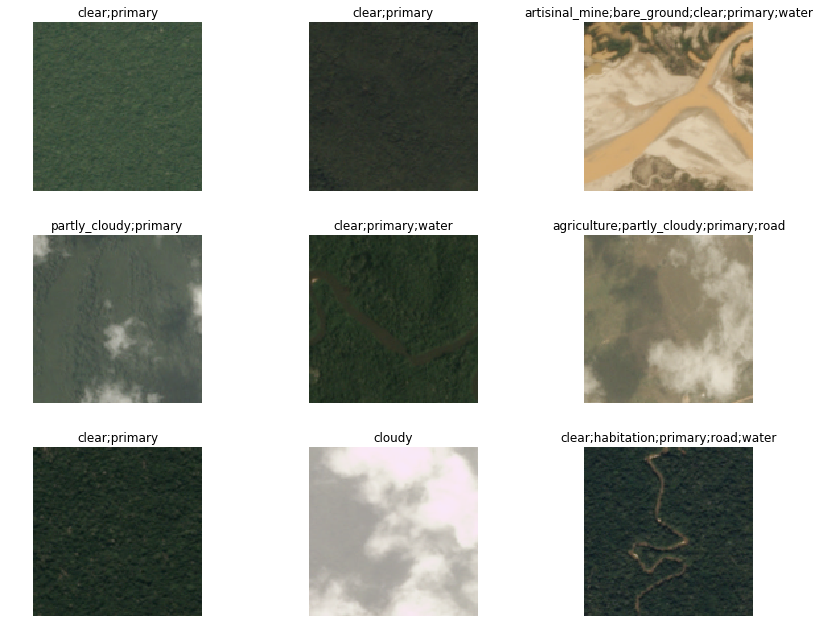

In [13]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [14]:
arch = models.resnet50

In [15]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


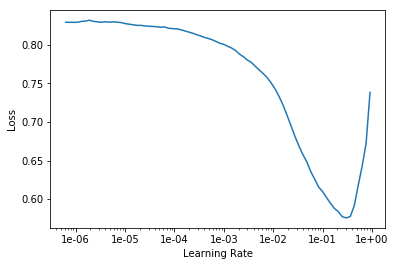

In [17]:
learn.recorder.plot()

Then we can fit the head of our network.

In [18]:
lr = 5*1e-02

In [19]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.129355,0.119338,0.950398,0.900434
2,0.134653,0.178067,0.948087,0.901737
3,0.119791,0.518973,0.957715,0.901795
4,0.099558,2.213440,0.953246,0.919697
5,0.094753,7.065657,0.954213,0.922153


In [20]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


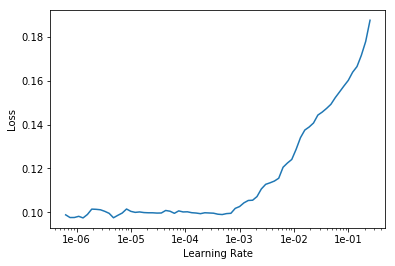

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.104703,0.326208,0.951757,0.914947
2,0.102846,0.092357,0.957497,0.921969
3,0.099552,0.091432,0.955797,0.921996
4,0.094454,0.111102,0.957621,0.925538
5,0.087904,0.186490,0.956124,0.926130


In [24]:
learn.save('stage-2-rn50')

## Use new databunch

In [25]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

# Insert new databunch!
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


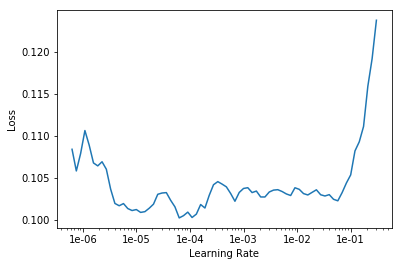

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


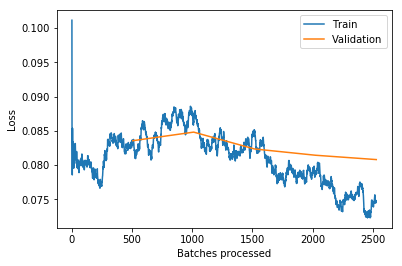

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99%|███████████████████████████████████████▋| 599M/603M [00:11<00:00, 88.6MB/s]
100%|████████████████████████████████████████| 603M/603M [00:11<00:00, 53.2MB/s]


In [ ]:
learn.load('stage-2-256-rn50')

In [ ]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

## Submission

In [27]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [ ]:
# ! 7za -bd -y x {path}/test-jpg-additional.tar.7z -o{path}
# ! tar -xf {path}/test-jpg-additional.tar -C {path}
# ! rsync -aP {path}/test-jpg-additional/ {path}/test-jpg/

In [38]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [39]:
len(learn.data.test_ds)

61191

In [40]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

### Have a look at the data structure of predictions

predictions contains prediction and target, two tensors

Since we are predicting on Test set, the target will be zero tensor

In [64]:
predictions[0][1]

tensor([9.7357e-01, 4.4394e-05, 9.8131e-03, 6.2475e-04, 4.9192e-04, 2.1678e-02,
        3.0164e-03, 3.0870e-05, 1.3659e-01, 7.1237e-03, 6.5433e-03, 9.4483e-01,
        9.8418e-01, 7.0703e-02, 2.3441e-04, 2.8185e-03, 8.1954e-02])

In [65]:
predictions[1][1]

tensor(0)

Each element in the prediction tensor, eg: `predictions[0]`, contains the possibility of each class. The index is corresponded to the `data.classes`

In [68]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

### Concat the multiple labels

In [83]:
def find_tags(pred, thresh):
    classes = ""
    for idx, val in enumerate(pred):
        if val > thresh:
            # Concat the string!
            classes = f'{classes} {learn.data.classes[idx]}'
    return classes.strip()

def predict(idx):
    pred_vals = predictions[0][idx]
    tags = find_tags(pred_vals, 0.2)
#     print(tags)
    img = learn.data.test_ds[idx][0]
    return img

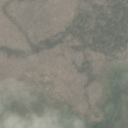

In [84]:
predict(1)

### Use TTA

In [85]:
# predictions = learn.TTA(ds_type=DatasetType.Test)

In [86]:
learn.data.test_ds.x.items

array([PosixPath('/scratch/zl2501/fastai_data/data/planet/test-jpg/file_4784.jpg'),
       PosixPath('/scratch/zl2501/fastai_data/data/planet/test-jpg/test_16526.jpg'),
       PosixPath('/scratch/zl2501/fastai_data/data/planet/test-jpg/test_13393.jpg'),
       PosixPath('/scratch/zl2501/fastai_data/data/planet/test-jpg/test_19271.jpg'), ...,
       PosixPath('/scratch/zl2501/fastai_data/data/planet/test-jpg/test_9338.jpg'),
       PosixPath('/scratch/zl2501/fastai_data/data/planet/test-jpg/test_11598.jpg'),
       PosixPath('/scratch/zl2501/fastai_data/data/planet/test-jpg/test_22913.jpg'),
       PosixPath('/scratch/zl2501/fastai_data/data/planet/test-jpg/test_11233.jpg')], dtype=object)

In [87]:
# Generate a single image's output by index
def get_row(idx):
    pred = predictions[0][idx]
    tags = find_tags(pred, 0.2)
    image_path = learn.data.test_ds.x.items[idx]
#     image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    image_name = image_path.stem
    return image_name, tags

In [88]:
get_row(4)

('test_26633', 'agriculture clear habitation primary road')

### Create result dataframe

In [89]:
# Create a empty dataframe
df = pd.DataFrame(columns=['image_name', 'tags'])

In [90]:
for idx in range(len(predictions[0])):
    if idx % 5000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    # Add new row to df
    df.loc[idx] = [image_name, tags]

Completed: 0
Completed: 5000
Completed: 10000
Completed: 15000
Completed: 20000
Completed: 25000
Completed: 30000
Completed: 35000
Completed: 40000
Completed: 45000
Completed: 50000
Completed: 55000
Completed: 60000


In [91]:
submission_path = f'submission.csv'

In [92]:
df.to_csv(submission_path, index=False)

In [93]:
!head {submission_path}

image_name,tags
file_4784,clear cloudy water
test_16526,agriculture partly_cloudy primary
test_13393,agriculture clear cultivation habitation haze primary road water
test_19271,clear primary
test_26633,agriculture clear habitation primary road
test_28542,agriculture clear habitation primary road
file_15737,clear primary
file_19607,agriculture clear cultivation habitation primary road water
file_15766,clear primary


In [94]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission.csv -m "without TTA"

100%|██████████████████████████████████████| 2.22M/2.22M [00:01<00:00, 1.89MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space